<a href="https://colab.research.google.com/github/PawelJakubczyk/mln_see_animals_classifier/blob/main/mnl_see_animals_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sorce

https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste?select=Jelly+Fish

# Install Libraries

In [1]:
%pip install tensorflow
%pip install keras
%pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


# Import Libraries

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
from google.colab import drive

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')



# Definine Function

In [3]:
def create_category_image_path_dataframe(folder_path):
    data = []
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(category_path, filename)
                    data.append({'Category': category, 'Image_Path': image_path})
    df = pd.DataFrame(data)
    df['Image_Path'] = df['Image_Path'].apply(lambda x: os.path.abspath(x))
    return df

## Augumentation

In [4]:
def balance_dataframe_by_record_reduction(df):
    # Calculate the minimum number of records in a category
    min_records = df['Category'].value_counts().min()

    # Function to remove random records from a group
    def remove_random_records(group):
        return group.sample(n=min_records, random_state=42)

    # Remove random records from the DataFrame
    df_balanced = df.groupby('Category', group_keys=False).apply(remove_random_records)

    return df_balanced

def rotate_image(image, angle):
    """Rotate the input image by the given angle (in degrees)."""
    # Get the image dimensions
    height, width = image.shape[:2]
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

    Rotacja: Obracanie obrazu o losowy kąt może pomóc w zwiększeniu różnorodności danych.

    Przesunięcie poziome/ pionowe: Przesunięcie obrazu w poziomie lub pionie może pomóc w zwiększeniu tolerancji na translację.

    Zoom: Losowe powiększanie lub pomniejszanie obrazu może pomóc w zwiększeniu elastyczności modelu.

    Zmiana jasności/kontrastu: Losowe zmiany jasności i kontrastu mogą pomóc w zwiększeniu odporności modelu na zmiany oświetlenia.

    Rozmycie: Zastosowanie rozmycia Gaussowskiego lub innego rodzaju rozmycia może pomóc w zmniejszeniu nadmiernego dopasowania.

    Elastyczne przekształcenia: Zastosowanie elastycznych przekształceń, takich jak deformacje lokalne, może pomóc w zwiększeniu odporności na zniekształcenia.

    Dodawanie szumu: Dodanie losowego szumu może pomóc w zwiększeniu ogólnej odporności modelu.

    Odbicie lustrzane: Odbicie obrazu w poziomie lub pionie może zwiększyć różnorodność danych.

    Kombinacja kilku technik: Często skuteczne jest zastosowanie kombinacji różnych technik augmentacji w celu uzyskania najlepszych rezultatów.

## Plot

In [ ]:
def plot_category_counts(df):
    # Counting the number of objects in each category
    category_counts = df['Category'].value_counts()

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of objects in each category')
    plt.xlabel('Category')
    plt.ylabel('Number of objects')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Connect to source and get data

In [5]:
drive.mount('/content/drive')

folder_path = Path(r'/content/drive/MyDrive/colab_assets/sea_animals_archive/')

Mounted at /content/drive


# Process and analyze the data

# Create dataframe

In [6]:
df_animals = create_category_image_path_dataframe(folder_path)
df_animals.head(10)

,Category,Image_Path
0,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
1,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
2,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
3,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
4,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
5,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
6,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
7,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
8,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
9,Eel,/content/drive/MyDrive/colab_assets/sea_animal...


In [ ]:
import matplotlib.pyplot as plt
import random

# Create a list of unique categories
categories = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

# Create a grid of plots where each row will contain one randomly selected image from each category
fig, axes = plt.subplots(nrows=len(categories), ncols=1, figsize=(5, 5*len(categories)))

# Iterate through each category
for category, ax in zip(categories, axes):
    # Select a random image from the current category
    random_image = df_animals[df_animals['Category'] == category].sample(1)
    image_path = random_image['Image_Path'].values[0]

    # Load and display the image
    image = plt.imread(image_path)
    ax.imshow(image)
    ax.set_title(category)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Augmentation

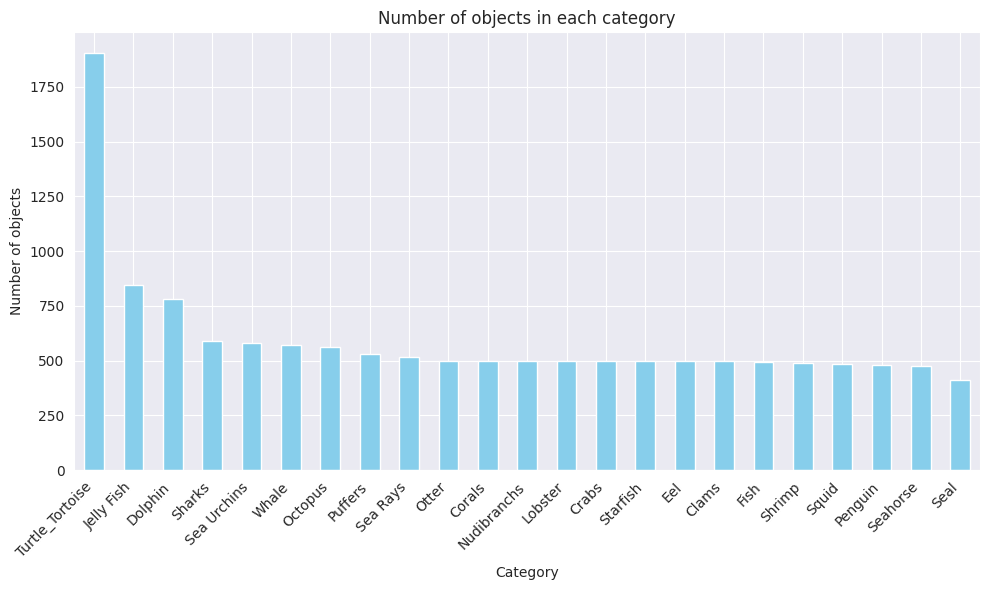

In [7]:
plot_category_counts(df_animals)

In [8]:
df_animals_balance = balance_dataframe(df_animals)

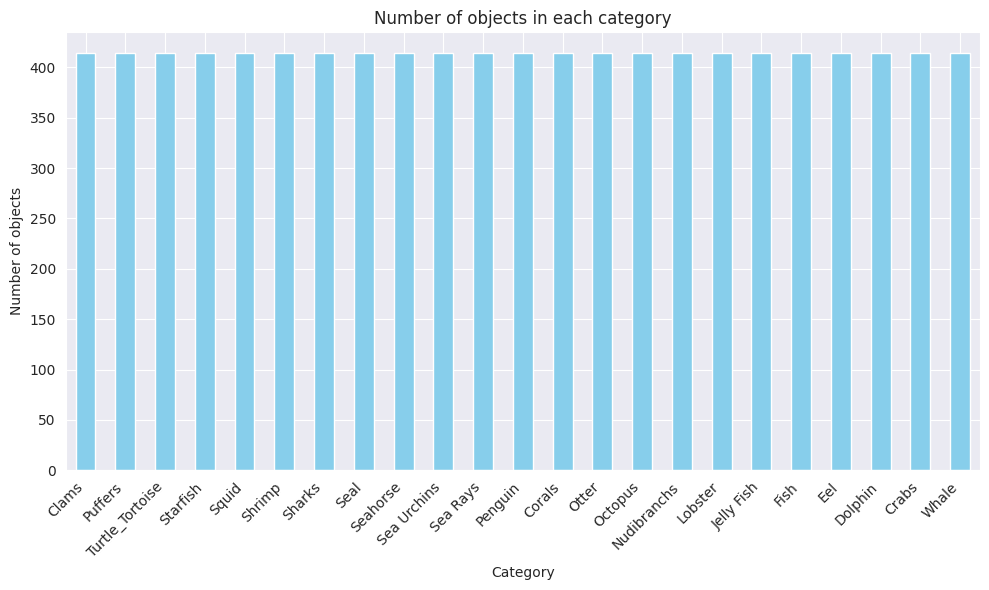

In [9]:
plot_category_counts(df_animals_balance)

# Build Model

In [32]:

X_train, X_test, y_train, y_test = train_test_split(df_animals_balance.Category, df_animals_balance.Image_Path, test_size=0.15, random_state=42)

In [11]:




print("folder list: ", folders)

folder list:  ['Eel', 'Nudibranchs', 'Clams', 'Jelly Fish', 'Octopus', 'Dolphin', 'Lobster', 'Crabs', 'Fish', 'Corals', 'Penguin', 'Shrimp', 'Seal', 'Squid', 'Puffers', 'Otter', 'Sharks', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Starfish', 'Turtle_Tortoise', 'Whale']


In [20]:
X_test.head(10)

8718     /content/drive/MyDrive/colab_assets/sea_animal...
8        /content/drive/MyDrive/colab_assets/sea_animal...
5360     /content/drive/MyDrive/colab_assets/sea_animal...
13306    /content/drive/MyDrive/colab_assets/sea_animal...
1041     /content/drive/MyDrive/colab_assets/sea_animal...
8810     /content/drive/MyDrive/colab_assets/sea_animal...
4969     /content/drive/MyDrive/colab_assets/sea_animal...
1633     /content/drive/MyDrive/colab_assets/sea_animal...
6303     /content/drive/MyDrive/colab_assets/sea_animal...
5371     /content/drive/MyDrive/colab_assets/sea_animal...
Name: Image_Path, dtype: object

In [34]:
# drive.mount('/content/drive')

# folder_path = Path(r'/content/drive/MyDrive/colab_assets/sea_animals_archive/')
# df_animals = create_category_image_path_dataframe(folder_path)
# df_animals_balance = balance_dataframe(df_animals)
df_animals_balance['Image_Path'] = df_animals_balance['Image_Path'].apply(lambda x: os.path.abspath(x))
X_train, X_test, y_train, y_test = train_test_split(df_animals_balance.Image_Path, df_animals_balance.Category, test_size=0.15, random_state=42)

In [ ]:
# Import niezbędnych bibliotek
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Zakoduj etykiety kategorii
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Definicja generatora obrazów dla zbioru treningowego z augmentacją danych
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Definicja generatora obrazów dla zbioru testowego (bez augmentacji)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Wczytanie i przygotowanie danych treningowych
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_animals_balance,
    x_col="Image_Path",
    y_col="Category",
    target_size=(224, 224),  # Rozmiar wejściowy modelu MobileNetV2
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

# Wczytanie i przygotowanie danych testowych
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_animals_balance,
    x_col="Image_Path",
    y_col="Category",
    target_size=(224, 224),  # Rozmiar wejściowy modelu MobileNetV2
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Budowa modelu transfer learningu z MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Budowa głowicy klasyfikacyjnej
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(len(label_encoder.classes_), activation="softmax")(head_model)

# Połączenie głowicy z bazowym modelem
model = Model(inputs=base_model.input, outputs=head_model)

# Zamrożenie wag bazowego modelu
for layer in base_model.layers:
    layer.trainable = False

# Kompilacja modelu
opt = Adam(lr=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Trenowanie modelu
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    epochs=20
)

# Ocena modelu na zbiorze testowym
predictions = model.predict(test_generator, steps=test_generator.samples // 32 + 1)
predicted_classes = label_encoder.inverse_transform(predictions.argmax(axis=-1))
print(classification_report(y_test, predicted_classes))


Found 9522 validated image filenames belonging to 23 classes.
Found 9522 validated image filenames belonging to 23 classes.


9406464/9406464 [==============================] - 0s 0us/step


Epoch 1/20
297/297 [==============================] - 2970s 10s/step - loss: 1.9035 - accuracy: 0.4443 - val_loss: 1.0078 - val_accuracy: 0.6997
Epoch 2/20
297/297 [==============================] - 1045s 4s/step - loss: 1.3293 - accuracy: 0.5989 - val_loss: 0.8641 - val_accuracy: 0.7413
Epoch 3/20
297/297 [==============================] - 983s 3s/step - loss: 1.2197 - accuracy: 0.6326 - val_loss: 0.7943 - val_accuracy: 0.7648
Epoch 4/20
297/297 [==============================] - ETA: 0s - loss: 1.1524 - accuracy: 0.6573

In [31]:
print(df_animals_balance.head())

     Category                                         Image_Path
1480    Clams  /content/drive/MyDrive/colab_assets/sea_animal...
1070    Clams  /content/drive/MyDrive/colab_assets/sea_animal...
1228    Clams  /content/drive/MyDrive/colab_assets/sea_animal...
1172    Clams  /content/drive/MyDrive/colab_assets/sea_animal...
1234    Clams  /content/drive/MyDrive/colab_assets/sea_animal...
